In [1]:
import os
import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)

Welcome to ROOTaaS 6.05/02


/swshare/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/swshare/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


<module 'training_utils' from '/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.pyc'>

In [2]:
ntuples = '20170526'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s]
diphotonJets = [s for s in files if "DiPhotonJets" in s]
gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
gJets_highPt = [s for s in files if "GJet_Pt-40" in s]

utils.IO.add_signal(ntuples,signal,1)
utils.IO.add_background(ntuples,diphotonJets,-1)
utils.IO.add_background(ntuples,gJets_lowPt,-2)
utils.IO.add_background(ntuples,gJets_highPt,-2)

for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526
using background file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.2: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using signal file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/AllNonResSig_20170526.root


In [3]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,DiJetDiPho_DR'.split(",")
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()'.split(",")
branch_names = [c.strip() for c in branch_names]
#branch_names = (b.replace(" ", "_") for b in branch_names)
#branch_names = list(b.replace("-", "_") for b in branch_names)
print branch_names

import pandas as pd
import root_pandas as rpd

#utils.IO.get_cross_sections('jsons/datasets80X_Moriond.json')
#utils.IO.w_sig.append(utils.IO.get_weight('signal','nrSM',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','DiPhoJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',1))


utils.preprocessing.set_signals_and_backgrounds("bbggSelectionTree",branch_names)
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=utils.preprocessing.set_variables(branch_names)

#relative weighting between components of one class is kept, all classes normalized to the same
#weights_sig=utils.preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
weights_sig=utils.preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
weights_bkg,weights_sig=utils.preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

X_bkg,y_bkg,weights_bkg = utils.preprocessing.randomize(X_bkg,y_bkg,weights_bkg)
X_sig,y_sig,weights_sig = utils.preprocessing.randomize(X_sig,y_sig,weights_sig)

print X_bkg.shape
print y_bkg.shape
#bbggTrees have by default signal and CR events, let's be sure that we clean it
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=utils.preprocessing.clean_signal_events(X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig)
print X_bkg.shape
print y_bkg.shape

y_total_train = utils.preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()
X_total_train = utils.preprocessing.get_total_training_sample(X_sig,X_bkg)

y_total_test = utils.preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()
X_total_test = utils.preprocessing.get_total_test_sample(X_sig,X_bkg)

w_total_train = utils.preprocessing.get_total_training_sample(weights_sig,weights_bkg).ravel()
w_total_test = utils.preprocessing.get_total_test_sample(weights_sig,weights_bkg).ravel()

['leadingJet_bDis', 'subleadingJet_bDis', 'noexpand:fabs(CosThetaStar_CS)', 'noexpand:fabs(CosTheta_bb)', 'noexpand:fabs(CosTheta_gg)', 'noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M()', 'noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverMDecorr', 'DiJetDiPho_DR']
(2254174, 13)
(2254174, 1)
(1922962, 13)
(1922962, 1)


In [4]:
import xgboost as xgb
#FIXME parameteres
clf = xgb.XGBClassifier(max_depth=10,learning_rate=0.2,n_estimators=500, min_child_weight=1e-5, nthread= 12)
#clf = xgb.XGBClassifier(max_depth=5,learning_rate=0.1,n_estimators=500, min_child_weight=1e-5, nthread= 12)
clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1e-05, missing=None, n_estimators=500, nthread=12,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [5]:
from sklearn.externals import joblib
joblib.dump(clf, os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC_resWeighting.pkl'), compress=9)

['/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/output_files/allMC_resWeighting.pkl']

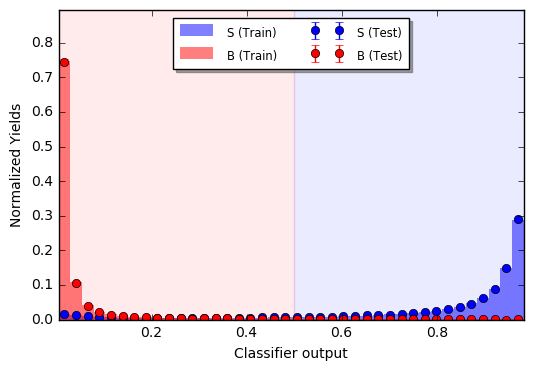

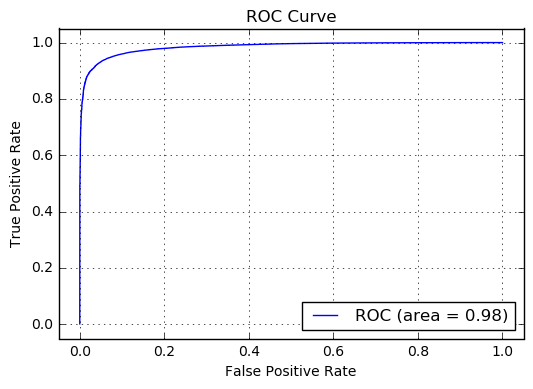

======== ROC report ========
0
True positive rate: 0.0
False positive rate:0.0
1
True positive rate: 0.05
False positive rate:0.0
2
True positive rate: 0.1
False positive rate:0.0
3
True positive rate: 0.15
False positive rate:0.0
4
True positive rate: 0.2
False positive rate:0.0
5
True positive rate: 0.25
False positive rate:0.0
6
True positive rate: 0.3
False positive rate:8.98391878537e-05
7
True positive rate: 0.35
False positive rate:8.98391878537e-05
8
True positive rate: 0.4
False positive rate:8.98391878537e-05
9
True positive rate: 0.45
False positive rate:0.000179678375707
10
True positive rate: 0.5
False positive rate:0.000449195939269
11
True positive rate: 0.55
False positive rate:0.00071871350283
12
True positive rate: 0.6
False positive rate:0.00134758781781
13
True positive rate: 0.65
False positive rate:0.00143742700566
14
True positive rate: 0.7
False positive rate:0.0025154972599
15
True positive rate: 0.75
False positive rate:0.003683406702
16
True positive rate: 0.

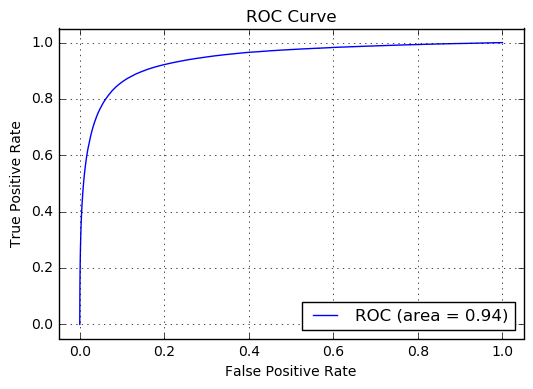

======== ROC report ========
0
True positive rate: 0.0
False positive rate:2.10448782028e-06
1
True positive rate: 0.05
False positive rate:5.89256589677e-05
2
True positive rate: 0.1
False positive rate:0.0002283369285
3
True positive rate: 0.15
False positive rate:0.000482979954754
4
True positive rate: 0.2
False positive rate:0.000861787762403
5
True positive rate: 0.25
False positive rate:0.00139211869311
6
True positive rate: 0.3
False positive rate:0.0021276371863
7
True positive rate: 0.35
False positive rate:0.00310727626664
8
True positive rate: 0.4
False positive rate:0.00446361866681
9
True positive rate: 0.45
False positive rate:0.00641237438838
10
True positive rate: 0.5
False positive rate:0.0089261850897
11
True positive rate: 0.55
False positive rate:0.0122649550166
12
True positive rate: 0.6
False positive rate:0.016755932025
13
True positive rate: 0.65
False positive rate:0.0229662755827
14
True positive rate: 0.7
False positive rate:0.0313316146683
15
True positive r

In [8]:
import matplotlib.pyplot as plt

utils.plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg_resWeight")
plt.show()
fpr,tpr = utils.plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString="xgbr_gJets_resWeighting")
plt.show()
utils.plotting.print_roc_report(fpr,tpr,step=0.05)
fpr,tpr = utils.plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString="xgbr_diphotons_resWeighting")
plt.show()
utils.plotting.print_roc_report(fpr,tpr,step=0.05)

In [103]:
print weights_bkg
print type (weights_bkg)
print type (y_bkg)
print weights_bkg.shape
print np.where(np.asarray(y_bkg)==-1)[0]
weights_2 = np.asarray(weights_bkg)[np.where(np.asarray(y_bkg)==-1)[0]]
print weights_2.shape
print np.where(weights_2==0)
ind = np.asarray(weights_2)[np.where(weights_2==0)]
print ind.shape

[  2.64622931e-07   5.29245862e-07   5.29245862e-07 ...,   2.64622931e-07
   5.29245862e-07   1.32311465e-06]
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(2254174,)
[      0       1       2 ..., 2254171 2254172 2254173]
(2190915,)
(array([     13,      14,      17, ..., 2190905, 2190906, 2190909]),)
(290231,)
